#Exercício em Python - Tema 9 - Modelos hidrológicos


Neste exercício, vamos construir um modelo hidrológico conceitual simples baseado no modelo de reservatório linear. Este modelo assume que o escoamento superficial é proporcional ao volume de água armazenado em um "reservatório" fictício, sendo útil para estimar o escoamento de uma bacia hidrográfica. Para isso, foi implementado o modelo conceitual hymod.


## 1. Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from decimal import Decimal

### Read files - Google Drive

In [ ]:
#Conexao com o Google Drive. Pode-se conectar com outras plataformas ou usar dados locais
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##%cd /content/drive/Shareddrives/Projeto Exercícios CABra/Exercícios/Exercicios_Mudancas_Climaticas/Dados
%cd /content/drive/MyDrive/CABra_climate_daily_series/

/content/drive/MyDrive/CABra_climate_daily_series


## Obter a série de dados de precipitação diária

In [ ]:
#Colocar o id da bacia hidrográficas do CABra
id_bacia = 378 #

#Colocar o caminho (link) dos dados
caminho = "/content/drive/MyDrive/CABra_climate_daily_series/climate_daily/ens/"+"CABra_"+str(id_bacia)+"_climate_"+"ENS"+".txt"

#Lendo as informacoes
precipitacao_dados = pd.read_csv(caminho,
                                 encoding='latin',
                                 delimiter='\t',
                                 skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,14]
                  )


data = []
for i in range(len(precipitacao_dados)):
  data.append(datetime.strptime(str(precipitacao_dados[' Year'][i])+"/"+str(precipitacao_dados[' Month'][i])+"/"+str(precipitacao_dados['   Day'][i]),"%Y/%m/%d").date())

precipitacao_dados['data'] = data


precipitacao_dados = precipitacao_dados.rename(columns={'     PREC': 'PREC'})
precipitacao_dados = precipitacao_dados.rename(columns={' Year': 'Year'})
precipitacao_dados = precipitacao_dados.rename(columns={' Month': 'Month'})
precipitacao_dados = precipitacao_dados.rename(columns={'   Day': 'Day'})




In [ ]:
#Colocar o caminho (link) dos dados
caminho = "/content/drive/MyDrive/CABra_climate_daily_series/streamflow_daily/"+"CABra_"+str(id_bacia)+"_streamflow"+".txt"

#Lendo as informacoes
streamflow_dados = pd.read_csv(caminho,
                                 encoding='latin',
                                 delimiter='\t',
                                 skiprows=[0,1,2,3,4,5,6,7,9]
                  )

data = []
for i in range(len(streamflow_dados)):
  data.append(datetime.strptime(str(streamflow_dados[' Year'][i])+"/"+str(streamflow_dados[' Month'][i])+"/"+str(streamflow_dados['   Day'][i]),"%Y/%m/%d").date())

streamflow_dados['data'] = data

streamflow_dados

,Year,Month,Day,Streamflow,Quality,data
0,1980,10,1,91.842,2,1980-10-01
1,1980,10,2,96.268,2,1980-10-02
2,1980,10,3,91.842,2,1980-10-03
3,1980,10,4,90.392,2,1980-10-04
4,1980,10,5,91.842,2,1980-10-05
...,...,...,...,...,...,...
10952,2010,9,26,NaN,2,2010-09-26
10953,2010,9,27,NaN,2,2010-09-27
10954,2010,9,28,NaN,2,2010-09-28
10955,2010,9,29,NaN,2,2010-09-29


## Modelo hidrológico

In [ ]:
def hymod(data, param, area, tdelta, e, p, w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365):
    cmax = param[0]
    beta = param[1]
    alfa = param[2]
    kslow = param[3]
    kquick = param[4]

    area = area * 1e6  # Convert area to m²
    fatconv = 1 / 1000 / tdelta * area
    ntstep = len(p)

    w2 = w_initial
    wslow = wslow_initial
    wquick = [wquick_initial] * 3  # Initialize wquick as a list of three elements

    c1 = 0
    w1 = np.zeros(ntstep)
    er1 = np.zeros(ntstep)
    er2 = np.zeros(ntstep)
    er = np.zeros(ntstep)
    ep = np.zeros(ntstep)
    qslow = np.zeros(ntstep)
    qtquick = np.zeros(ntstep)
    qtslow = np.zeros(ntstep)
    qtot = np.zeros(ntstep)

    for i in range(ntstep):
        w1[i] = w2
        dummy = (1 - ((beta + 1) * w1[i] / cmax))
        dummy = max(dummy, 0)
        c1 = cmax * (1 - (dummy ** (1 / (beta + 1))))

        c2 = min(c1 + p[i], cmax)
        er1[i] = max((p[i] - cmax + c1), 0)
        dummy = 1 - c2 / cmax
        dummy = max(dummy, 0)
        w2 = (cmax / (beta + 1)) * (1 - (dummy ** (beta + 1)))

        er2[i] = max((c2 - c1) - (w2 - w1[i]), 0)
        ep[i] = (1 - (((cmax - c2) / (beta + 1)) / (cmax / (beta + 1)))) * e[i]
        w2 = max(w2 - ep[i], 0)

        uquick = alfa * er2[i] + er1[i]
        uslow = (1 - alfa) * er2[i]
        wslow = (1 - kslow) * wslow + (1 - kslow) * uslow
        qslow[i] = (kslow / (1 - kslow)) * wslow

        qquick = 0
        for j in range(3):
            wquick[j] = (1 - kquick) * wquick[j] + (1 - kquick) * uquick
            qquick = (kquick / (1 - kquick)) * wquick[j]
            uquick = qquick

        qtslow[i] = qslow[i] * fatconv
        qtquick[i] = qquick * fatconv
        qtot[i] = qtquick[i] + qtslow[i]

    return({
        "w_tot": w1[warmup:],
        "ep_tot": ep[warmup:],
        "q_slow": qtslow[warmup:],
        "q_quick": qtquick[warmup:],
        "streamflow": qtot[warmup:],
        "data": data[warmup:]
    })


## Estudo de caso

In [ ]:
e = precipitacao_dados['   PET PM']
p = precipitacao_dados['PREC']
data = precipitacao_dados['data']
area = 10789.38

param = [847.9494, 0.4592565, 0.379336, 0.007841399, 0.344429]
resultados = hymod(data,
                   param,
                   area,
                   86400,
                   e,
                   p,
                   w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365
                                )

resultados

{'w_tot': array([481.10411873, 490.26026663, 505.41905451, ..., 469.31707652,
        485.87958673, 504.50750629]),
 'ep_tot': array([2.57505534, 2.88023361, 2.30599288, ..., 2.17516881, 1.84386924,
        2.58872823]),
 'q_slow': array([106.78036456, 115.31654255, 121.09884301, ..., 112.44742833,
        121.93299934, 126.95094331]),
 'q_quick': array([143.99866934, 187.20299462, 238.16932262, ..., 187.40882413,
        243.56238579, 299.19017112]),
 'streamflow': array([250.7790339 , 302.51953718, 359.26816563, ..., 299.85625245,
        365.49538513, 426.14111443]),
 'data': 365      1980-12-31
 366      1981-01-01
 367      1981-01-02
 368      1981-01-03
 369      1981-01-04
             ...    
 11318    2010-12-27
 11319    2010-12-28
 11320    2010-12-29
 11321    2010-12-30
 11322    2010-12-31
 Name: data, Length: 10958, dtype: object}

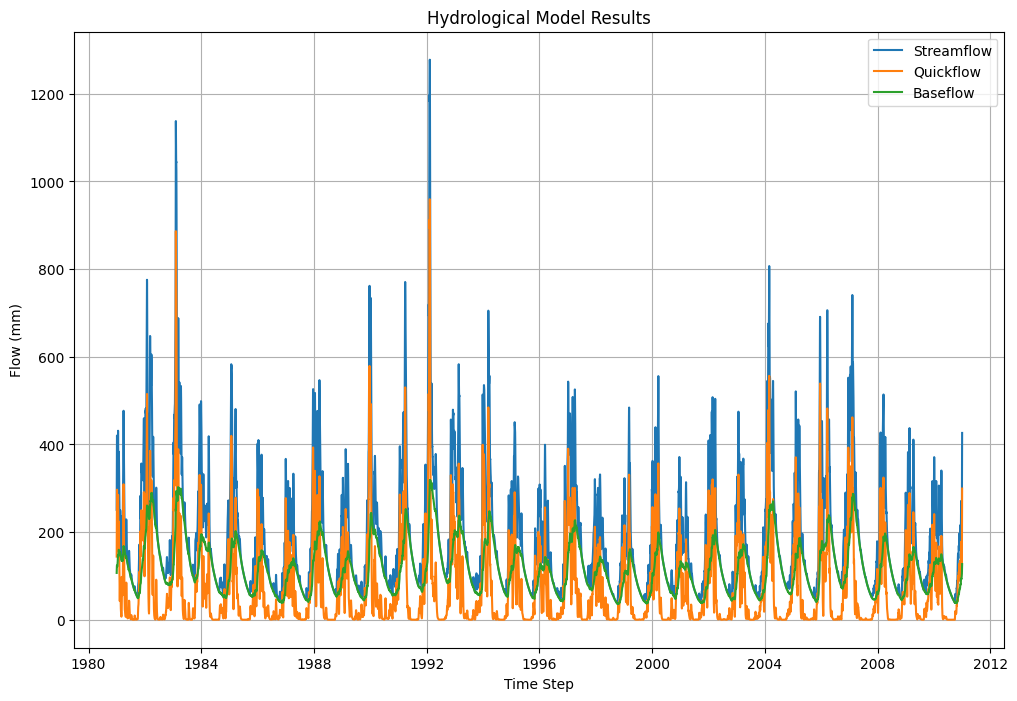

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(resultados['data'],resultados['streamflow'], label='Streamflow')
plt.plot(resultados['data'],resultados['q_quick'], label='Quickflow')
plt.plot(resultados['data'],resultados['q_slow'], label='Baseflow')

plt.xlabel('Time Step')
plt.ylabel('Flow (mm)')
plt.title('Hydrological Model Results')
plt.legend()
plt.grid(True)
plt.show()



### Comparação de dado simulado vs observado

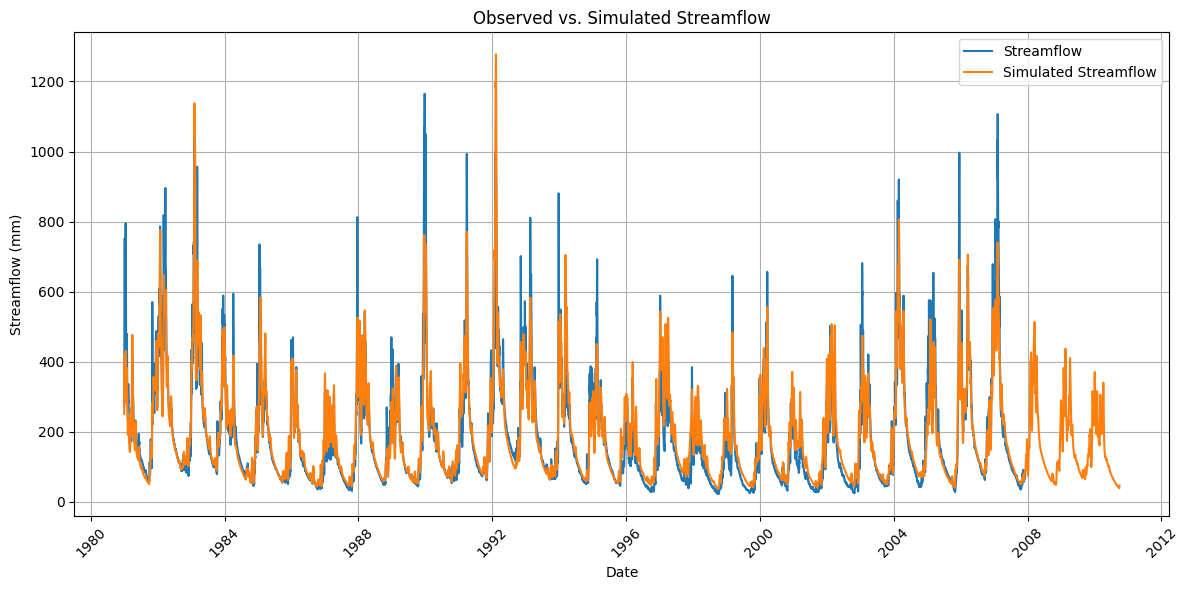

In [ ]:
# Convert streamflow to a DataFrame
streamflow_simulated = pd.DataFrame({'data': resultados['data'], 'streamflow_simulated': resultados['streamflow']})

# Merge the DataFrames
merged_df = pd.merge(streamflow_dados, streamflow_simulated, on='data', how='inner')
merged_df[' Streamflow'] = merged_df[' Streamflow'].astype(float)
# Display the merged DataFrame
merged_df

plt.figure(figsize=(12, 6))
plt.plot(merged_df['data'], merged_df[' Streamflow'], label='Streamflow')
plt.plot(merged_df['data'], merged_df['streamflow_simulated'], label='Simulated Streamflow')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.title('Observed vs. Simulated Streamflow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def calculate_performance_metrics(observed, simulated):
    """Calculates performance metrics for hydrological model simulations.

    Args:
        observed: A NumPy array of observed values.
        simulated: A NumPy array of simulated values.

    Returns:
        A dictionary containing the performance metrics.
    """

    # Remove NaN values for calculations
    mask = ~np.isnan(observed) & ~np.isnan(simulated)
    observed = observed[mask]
    simulated = simulated[mask]

    # Calculate metrics
    r2 = np.corrcoef(observed, simulated)[0, 1] ** 2  # R-squared
    nse = 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2) # Nash-Sutcliffe efficiency
    pbias = 100 * np.sum(simulated - observed) / np.sum(observed) # Percent bias
    rmse = np.sqrt(np.mean((observed - simulated) ** 2))  # Root mean squared error


    return {
        "R-squared": r2,
        "Nash-Sutcliffe Efficiency": nse,
        "Percent Bias": pbias,
        "RMSE": rmse
    }

# Example usage (assuming 'merged_df' is your DataFrame):
observed_streamflow = merged_df[' Streamflow'].values
simulated_streamflow = merged_df['streamflow_simulated'].values

metrics = calculate_performance_metrics(observed_streamflow, simulated_streamflow)
metrics

{'R-squared': 0.8890318319939453,
 'Nash-Sutcliffe Efficiency': 0.8848644854325874,
 'Percent Bias': 5.309845968968426,
 'RMSE': 51.358670941476994}

### Análise de sensibilidade de Cmax

In [ ]:
def objective_function(param, p, e):

    resultados = hymod(data,
                   param,
                   area,
                   86400,
                   e,
                   p,
                   w_initial=0, wslow_initial=0, wquick_initial=0,warmup=365
                                )

    streamflow_simulated = pd.DataFrame({'data': resultados['data'], 'streamflow_simulated': resultados['streamflow']})


    merged_df = pd.merge(streamflow_dados, streamflow_simulated, on='data', how='inner')
    merged_df[' Streamflow'] = merged_df[' Streamflow'].astype(float)

    simulated = merged_df['streamflow_simulated']
    observed = merged_df[' Streamflow']
    nse = 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2) # Nash-Sutcliffe efficiency

    return(nse)

### Criação de amostragem pelo método dos hipercubos latinos

In [ ]:
from scipy.stats import qmc

# Definir o número de dimensões e amostras
dimensions = 1 # Demensões (números de parâmetros testados)
samples = 100 # número de amostras

# Create a LatinHypercube instance
lhs = qmc.LatinHypercube(d=dimensions)

sample = lhs.random(n=samples)

# Scale the samples to the desired range, if needed
scaled_sample = qmc.scale(sample, l_bounds=[100], u_bounds=[1000])
scaled_sample_df = pd.DataFrame(scaled_sample, columns=['Cmax'])

cmax_values = scaled_sample_df['Cmax'].values
cmax_values

array([654.93123201, 950.3773902 , 485.56829094, 200.02063173,
       182.02091075, 586.52136135, 495.45290885, 712.74159071,
       729.78781805, 578.42787838, 116.0881113 , 477.52873061,
       751.8189661 , 190.51722687, 956.59859501, 698.06936252,
       122.84845372, 360.33621577, 802.63152982, 646.50019002,
       926.34315618, 421.00892234, 269.91707662, 999.14562363,
       690.65802246, 871.64549269, 430.72910724, 255.24674129,
       915.72492746, 461.69470108, 635.8591979 , 274.43537309,
       217.30948256, 608.58118036, 599.09708268, 339.09662816,
       676.75145224, 537.11258491, 547.30072535, 403.06972398,
       248.54751192, 299.12141842, 453.78222334, 896.07538729,
       902.37906417, 231.88962754, 444.5150215 , 795.06223774,
       614.2599701 , 788.1591655 , 739.63254237, 436.16874552,
       169.55369263, 939.50418944, 517.56494922, 236.34310439,
       154.35028446, 500.88454858, 381.69859743, 972.8918178 ,
       317.37962771, 887.52038594, 829.22984768, 571.62

In [ ]:

e = precipitacao_dados['   PET PM']
p = precipitacao_dados['PREC']
data = precipitacao_dados['data']
area = 10789.38

output = []
for cmax in cmax_values:
      param = [cmax,  0.4592565, 0.379336, 0.007841399, 0.344429]
      nse = objective_function(param, p, e)
      output.append([cmax, nse])


output_df = pd.DataFrame(output, columns=['cmax', 'NSE'])



,cmax,NSE
0,654.931232,0.860858
1,950.377390,0.886069
2,485.568291,0.801308
3,200.020632,0.304421
4,182.020911,0.228712
...,...,...
95,127.717737,-0.068155
96,663.981226,0.862391
97,838.094112,0.884358
98,366.585658,0.694437


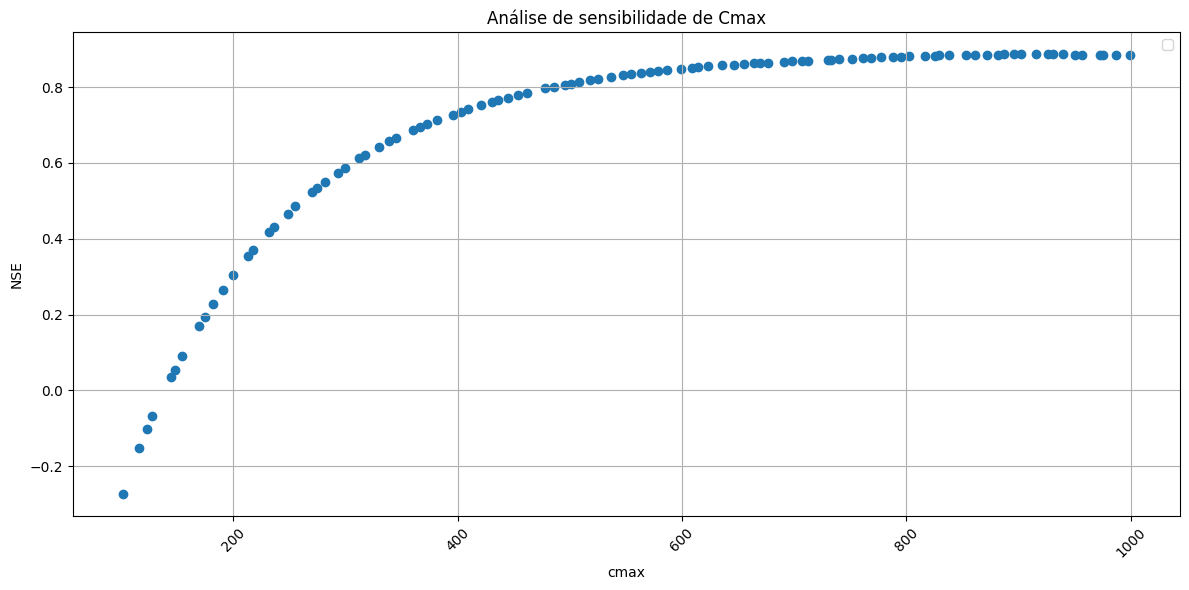

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(output_df['cmax'], output_df['NSE'])
plt.xlabel('cmax')
plt.ylabel('NSE')
plt.title('Análise de sensibilidade de Cmax')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()